# CRNN Training

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as torch_utils
import pandas as pd
from torch.utils.data import DataLoader,Dataset
import h5py
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="0"
!nvidia-smi

Mon Jun 15 15:53:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.51                 Driver Version: 396.51                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0  On |                  N/A |
| 23%   39C    P5    21W / 250W |   2180MiB / 11177MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   34C    P8    16W / 250W |   4401MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Construct custom dataloader

In [2]:
class Customdataset(Dataset):
    def __init__(self,second,dataset_type,transform=None):
        '''
        Call stored dataset
        
        Params
        second: Ellapsed second from the beginning of events 
        dataset_type: Type of dataset, trainset, validset, and testset
        '''
        filepath='./data/game_data/seconds_'+str(second)+'/'+dataset_type+'.hdf5'
        dataset = h5py.File(filepath,'r')
        
        # Transforms
        self.transform = transform
        self.x_data=dataset['image']
        self.y_data=dataset['label']
        self.timepoint = 1+ 2 * second 

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self,idx):
        
        # Convert x and y data to torch flaot tensor
        x = torch.FloatTensor(self.x_data[idx])
        x = x.view(self.timepoint,-1)
        if self.y_data[idx] ==0:
            y = [1,0]
        else:
            y = [0,1]
        y = torch.FloatTensor(y)
        
        return x,y

## Modeling CRNN

In [3]:
class Crnn(nn.Module):
    def __init__(self, input_size,hidden_size, num_layers, output_size,batch_size):
        super(Crnn,self).__init__()
        
        self.input_size =  input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        # GRU part
        self.gru = nn.GRU(6000,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.relu = nn.ReLU()


        # CNN part
        self.cnn1 = nn.Sequential(
            nn.Conv1d(input_size,6000,2,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.2)
        )

        self.cnn2 = nn.Sequential(
            nn.Conv1d(6000,6000,2,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.2)
        )

        # Linear        
        self.fcs =nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size,500),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(250, output_size),
        )
        
        
        
    def forward(self,inputs,hidden):        
        hidden = hidden.reshape(self.num_layers,batch_size,-1)        
        inputs = inputs.reshape(batch_size,-1,timepoint)
        output = self.cnn1(inputs)
        output = self.cnn2(output)
        output = output.reshape([batch_size,-1,output.shape[1]])
        
        output,hidden = self.gru(output,hidden)
        output = self.relu(output)
        output = self.fcs(output)
        output = output[:,-1]
 
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,batch_size,self.hidden_size)

In [5]:
loss_second_dict={}
vloss_second_dict={}
model_second={}
for second in range(8,11):
    print('Second: ',second, 'is now training')
    timepoint = 1+second*2
    batch_size =1
    dataset_type = 'trainset'

    trainset = Customdataset(second=second,dataset_type=dataset_type)
    train_loader = DataLoader(trainset, batch_size=batch_size)
    dataset_type = 'validset'

    validset = Customdataset(second=second,dataset_type=dataset_type)
    valid_loader = DataLoader(validset, batch_size=batch_size)

    n_hidden = 1000
    lr = 0.001
    epochs = 201

    model = Crnn(5824, n_hidden,1,2,batch_size)
    model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    
    loss_graph={}
    vloss_graph={}
    for epoch in range(epochs):
        hidden = model.initHidden()
        hidden = hidden.cuda()
        running_loss=0
        for x,y in train_loader:
            x = x.cuda()
            y= y.cuda()
            x = x.reshape(batch_size,timepoint,-1)
            optimizer.zero_grad()
            output,hidden = model(x,hidden)
            loss = criterion(output, y)
            running_loss += loss
            
        running_loss.backward()
        optimizer.step()
        loss_graph[epoch]= running_loss.item()
        
        if epoch%10 ==0:
            with torch.no_grad():
                val_loss=0.0
                for val_x,val_y in valid_loader:
                    val_x = val_x.cuda()
                    val_y = val_y.cuda()
                    val_output,_ = model(val_x,hidden)
                    v_loss = criterion(val_output,val_y)
                    val_loss +=v_loss
            vloss_graph[epoch]=val_loss.item()
        
        
        if epoch %50 ==0:
            print("epoch: {}, loss: {:.5f}, v_loss: {:.5f}".format(epoch, running_loss.data,val_loss.data))
    loss_second_dict[second]= loss_graph
    vloss_second_dict[second]= vloss_graph
    model_second[second] = model
    
    #Save model
    save_path = './data/game_data/CRNN_second_'+str(second)+'.pth'
    torch.save(model.state_dict(),save_path)
    pd.DataFrame(vloss_second_dict).to_csv('./data/vloss_second_'+str(second)+'dict.csv')
    pd.DataFrame(loss_second_dict).to_csv('./data/loss_second_'+str(second)+'dict.csv')

Second:  8 is now training


/home/suhwan/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


epoch: 0, loss: 314.34656, v_loss: 110.23411
epoch: 50, loss: 309.96545, v_loss: 105.46424
epoch: 100, loss: 309.55853, v_loss: 105.61726
epoch: 150, loss: 307.24411, v_loss: 107.60383
epoch: 200, loss: 307.13318, v_loss: 105.74189
Second:  9 is now training
epoch: 0, loss: 306.40149, v_loss: 103.52708
epoch: 50, loss: 302.86780, v_loss: 100.30707
epoch: 100, loss: 301.49310, v_loss: 100.93446
epoch: 150, loss: 302.35236, v_loss: 100.39127
epoch: 200, loss: 301.40884, v_loss: 99.71992
Second:  10 is now training
epoch: 0, loss: 298.45718, v_loss: 100.72720
epoch: 50, loss: 292.40585, v_loss: 98.28994
epoch: 100, loss: 294.30240, v_loss: 98.33392
epoch: 150, loss: 291.47607, v_loss: 98.54971
epoch: 200, loss: 292.01483, v_loss: 97.63597


In [6]:
pd.DataFrame(vloss_second_dict).to_csv('./data/CRNN/vloss_second_dict.csv')
pd.DataFrame(loss_second_dict).to_csv('./data/CRNN/loss_second_dict.csv')

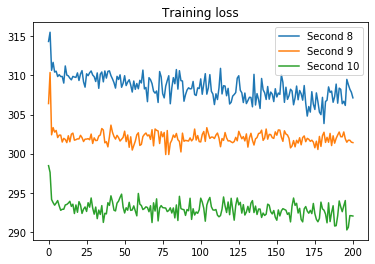

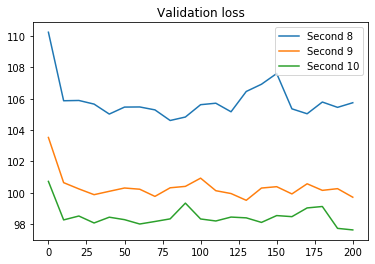

In [14]:
loss_second_dict={}
vloss_second_dict={}
loss_df = pd.read_csv('./data/CRNN/loss_second_dict.csv')
vloss_df = pd.read_csv('./data/CRNN/vloss_second_dict.csv')
loss_df = loss_df.drop(columns=['Unnamed: 0'],axis=1)

vloss_df = vloss_df.rename(columns={'Unnamed: 0':'Index'})


plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'8']),label='Second 8')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'9']),label='Second 9')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'10']),label='Second 10')
plt.title('Training loss')
plt.legend()
plt.show()
plt.cla()
plt.clf()

plt.plot(list(vloss_df['Index']),list(vloss_df.loc[:,'8']),label='Second 8')
plt.plot(list(vloss_df['Index']),list(vloss_df.loc[:,'9']),label='Second 9')
plt.plot(list(vloss_df['Index']),list(vloss_df.loc[:,'10']),label='Second 10')
plt.title('Validation loss')
plt.legend(loc='upper right')
plt.show()


In [9]:
batch_size=1
n_hidden = 1000

Accuracy_dict={}
for second in range(1,11):
    timepoint = 1+second*2

    model= Crnn(5824, n_hidden,1,2,batch_size).cuda()
    model.load_state_dict(torch.load("./data/game_data/CRNN_second_"+str(second)+'.pth'))
    
    hidden = model.initHidden().cuda()
    dataset_type='testset'
    testset = Customdataset(second=second,dataset_type=dataset_type)
    test_loader = DataLoader(testset, batch_size=batch_size)
    overall =0
    acc_count =0
    with torch.no_grad():
        for inputs, targets in test_loader:

            inputs, targets = inputs.cuda(), targets.cuda()   
            y,hidden = model(inputs,hidden)
            y = torch.argmax(y.data)
            target =torch.argmax(targets.data[0])       

            if y ==target:
                acc_count +=1
            overall +=1
    print('Second:',second,'Accuracy: ', acc_count*100/overall,'%')
    Accuracy_dict[second] = acc_count*100/overall
    

/home/suhwan/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Second: 1 Accuracy:  54.93827160493827 %
Second: 2 Accuracy:  62.11180124223603 %
Second: 3 Accuracy:  55.625 %
Second: 4 Accuracy:  57.861635220125784 %
Second: 5 Accuracy:  50.63291139240506 %
Second: 6 Accuracy:  50.64102564102564 %
Second: 7 Accuracy:  54.60526315789474 %
Second: 8 Accuracy:  61.58940397350993 %
Second: 9 Accuracy:  54.054054054054056 %
Second: 10 Accuracy:  53.84615384615385 %


[Text(0, 0, '50.00%'),
 Text(0, 0, '52.00%'),
 Text(0, 0, '54.00%'),
 Text(0, 0, '56.00%'),
 Text(0, 0, '58.00%'),
 Text(0, 0, '60.00%'),
 Text(0, 0, '62.00%'),
 Text(0, 0, '64.00%')]

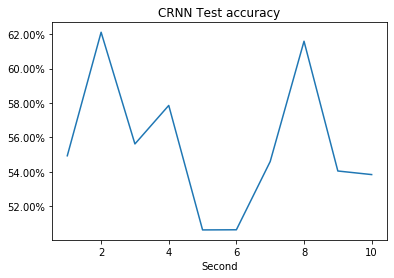

In [52]:
fig = plt.figure()
ax = fig.subplots()
ax.plot(list(Accuracy_dict.keys()),list(Accuracy_dict.values()))
ax.set_title('CRNN Test accuracy')
ax.set_xlabel('Second')
y_value = ['{:,.2f}'.format(x)+'%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)

## Number of model parameters

In [54]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params/1024)

159699.46484375
